# <center>Transfer Learning<br /> Workshop</center>

![logo_ecole_ing.jpg](attachment:logo_ecole_ing.jpg)
Concepteur : Mellila BOUAM
</div>

# Introduction

The aim of this workshop is to introduce you to [transfer learning](https://fr.wikipedia.org/wiki/Apprentissage_par_transfert), a technique used to exploit the knowledge acquired by a model trained on a large dataset on an application task where the quantity of available data is limited.

We will begin with an intuitive analysis of the effectiveness of transfer learning. We will then prepare the first part, i.e. the data to be used, of the [image annotations](https://fr.wikipedia.org/wiki/Annotation_automatique_d%27images) (image captioning) workshop in which we are going to train a model using transfer learning.

## What is transfer learning?

**Transfer Learning** consists of taking features learnt on one problem, and using them on another similar problem. For example, the features of a model that has learned to recognise cats can be used to initialise a model that will recognise tigers.

Transfer learning is often carried out on tasks where the dataset contains too few examples to train a model from scratch.

The typical workflow for transfer learning in the context of deep learning is as follows:

1. Take layers from a pre-trained model.
2. Freeze the weights of these layers.
3. Add trainable layers (whose weights are not frozen) at the end of the model. These will be used to convert features into predictions on a new dataset.
4. Train the new layers on the new dataset.

- What is the point of freezing the weights of the layers in the pre-trained model (step 2)? \

*Utilizing Pre-trained Features: Pre-trained models (like VGG, ResNet, Inception, etc.) have already learned to extract features from a vast dataset (e.g., ImageNet) that can be relevant to many tasks. By freezing the weights, you leverage these learned features without altering them, ensuring that the foundational representations are preserved*.

*Preventing Overfitting: In many cases, the new dataset for which you're fine-tuning the model may be smaller than the dataset used for pre-training. Training all layers can lead to overfitting, where the model learns noise and specific details of the smaller dataset instead of generalizing well. Freezing some layers helps mitigate this risk.*

*Faster Training: Freezing layers reduces the number of parameters that need to be updated during training. This can significantly speed up the training process since the optimizer doesn’t have to compute gradients and update weights for these layers.*

*Training Efficiency: By only training the last few layers (or a selected subset of layers), you can focus computational resources and time on optimizing the parts of the model that are most relevant to your specific task. This is especially beneficial in scenarios where computational power is limited.*

*Layer Specialization: In deep networks, lower layers typically learn general features (like edges, colors, textures), while higher layers learn more specific features (like shapes or object parts). Freezing lower layers allows you to keep these general features intact while modifying the higher layers to adapt to your specific task.*

*Simplifying the Training Process: With fewer parameters to tune, the training process can be more stable and straightforward. This allows you to use simpler optimizers and learning rates without worrying about complex interactions among many trainable parameters.*

A final optional step, **fine-tuning** consists of unfreezing all the layers of the model obtained after the previous process and re-training it on the new dataset with a very low learning rate.

- What is the point of the fine-tuning stage? Why is a very low learning rate used? <br>

*Fine-tuning allows a pre-trained model to adapt its learned features to a specific task by making careful adjustments to the weights. Using a very low learning rate during this stage ensures that these adjustments are small, helping to preserve the valuable information learned during pre-training while allowing for adaptation to the new data. This careful balance leads to improved performance and generalization on the new task.*

# Part 1: Intuition on transfer learning

In this section, we will load the [InceptionV3](https://paperswithcode.com/method/inception-v3) model pre-trained on a classification task on the [ImageNet](https://image-net.org/) dataset. We will then use this model to compute vector representations (called [embeddings](https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture?hl=fr)) of images from the [cats vs dogs] dataset (https://www.tensorflow.org/datasets/catalog/cats_vs_dogs). We will then represent each embedding on the map and interpret the results.

## Loading the data
We first load the cats vs. dogs dataset using [TFDS](https://www.tensorflow.org/datasets?hl=fr) (TensorFlow Datasets).

Transfer learning works particularly well on small datasets. Complete the code below, you need to display the number of examples in each dataset.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

In [2]:
import zipfile
import os

# Specify the path to the ZIP file
zip_file_path = 'D:/CESI/Datasets/kagglecatsanddogs_5340.zip'

# Specify a directory to extract the files
extract_dir = 'extracted_dataset'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to {extract_dir}")

Files extracted to extracted_dataset


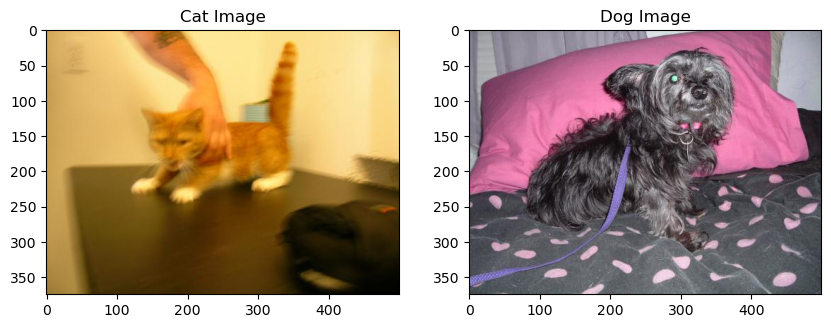

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Specify the folder where images are stored after extraction
cat_image_folder = os.path.join(extract_dir, 'PetImages/Cat')
dog_image_folder = os.path.join(extract_dir, 'PetImages/Dog')

# Load a specific image (e.g., the first one) from each folder
cat_image_path = os.path.join(cat_image_folder, '0.jpg')
dog_image_path = os.path.join(dog_image_folder, '0.jpg')

# Open the images
cat_image = Image.open(cat_image_path)
dog_image = Image.open(dog_image_path)

# Display the images using matplotlib
plt.figure(figsize=(10, 5))

# Show the cat image
plt.subplot(1, 2, 1)
plt.imshow(cat_image)
plt.title('Cat Image')

# Show the dog image
plt.subplot(1, 2, 2)
plt.imshow(dog_image)
plt.title('Dog Image')

plt.show()

Let's visualize the first 9 images of the dataset. We will notice that class 0 corresponds to "cat" and class 1 corresponds to dog.

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Number of training samples: 625
Number of validation samples: 79
Number of test samples: 78


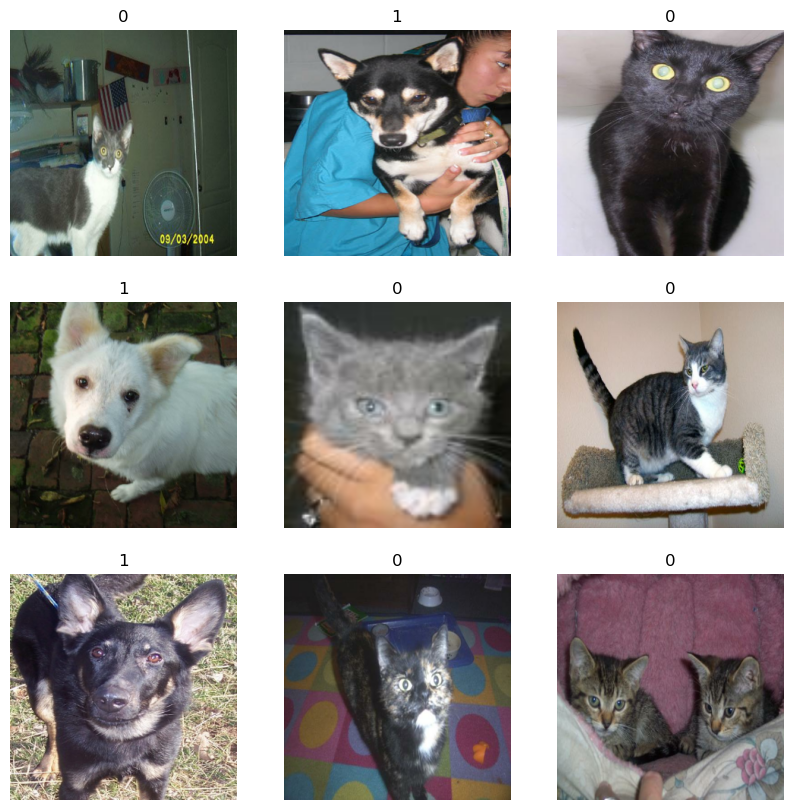

In [4]:
dataset_dir=r'D:\CESI\Datasets\kagglecatsanddogs_5340\PetImages'
# Load the dataset and divide it into training, validation and test sets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',      # Inferring labels from folder structure
    label_mode='int',       # Labels as integers (cats = 0, dogs = 1)
    image_size=(299, 299),  # Resize images to a standard size
    validation_split=0.2,   # Reserve 20% of data for validation and testing
    subset='training',      # This part is the training package
    seed=17,                # for reproducity urposes
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    image_size=(299, 299),
    validation_split=0.2,
    subset='validation',    # Validation set
    seed=123,
)

# divide the validation set into validation and test
validation_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(validation_batches // 2)
validation_ds = validation_ds.skip(validation_batches // 2)

# Display the number of examples in each set
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds).numpy())
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds).numpy())
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds).numpy())

#here are some examples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image_batch, label_batch) in enumerate(train_ds.take(9)):
    # Extraire la première image et le premier label du batch
    image = image_batch[0].numpy().astype("uint8")
    label = label_batch[0].numpy()

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")



## Data Standardization
The images in the dataset are of different sizes. So we need to resize them to match the size expected by the model we are going to use: InceptionV3.

We resize the images to a size of (299x299). To do this, you will need an image resizing function, which [TensorFLow will provide you](https://www.tensorflow.org/api_docs/python/tf/image/resize). Alternatively, if you want to do the resizing in a single statement, you can use [lambda expressions](https://www.w3schools.com/python/python_lambda.asp)

In [5]:
#Resize the images
size=(299,299)

train_ds = train_ds.map(lambda x, y:(tf.image.resize(x, size),y))
validation_ds = validation_ds.map(lambda x, y:(tf.image.resize(x, size),y))
test_ds = test_ds.map(lambda x, y:(tf.image.resize(x, size),y))

In [6]:
#Resize the images using format image method

#size = 299

#def format_image(image, label):
    #image = tf.cast(image, tf.float32) / 255.0  # Normalize the pixel values
    #image = tf.image.resize(image, (size, size))  # Resize to the desired size
    #return image, label
#batch_size = 32

#train_ds = train_ds.map(format_image).shuffle(1000).batch(batch_size)
#validation_ds = validation_ds.map(format_image).shuffle(1000).batch(batch_size)
#test_ds = test_ds.map(format_image).shuffle(1000).batch(batch_size)


In [7]:
 # We pre-process the images so that we can give them as input to InceptionV3

train_ds = train_ds.map(lambda x, y:(tf.keras.applications.inception_v3.preprocess_input(x),y))
validation_ds = validation_ds.map(lambda x, y:(tf.keras.applications.inception_v3.preprocess_input(x),y))
test_ds = test_ds.map(lambda x, y:(tf.keras.applications.inception_v3.preprocess_input(x),y))


In [8]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


In [9]:
# Download the pre-trained InceptionV3 model with cassification from ImageNet

# If we set weights=None -> we'll get embeddings that don't contain any info
# If we set weights='imagenet' -> we'll get semantically relevant embeddings even if the model hasn't been trained on cats vs dogs or cifar10
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet', pooling='avg')

À quoi correspond le paramètre **include_top = false** ?<br>
<em> The goal is to remove the last layer to modify according to the new dataset</em>

À quoi correspond le paramètre **weights='imagenet'** ? <br>
<em> This specifies the weights to initialize the model.To load weights that have been pre-trained on the ImageNet dataset.</em>

À quoi correspond le paramètre **pooling='avg'** ?<br>
<em> The average pooling is applied to the feature maps, resulting in a fixed-size output vector</em>


We now define the [model to be used](https://www.tensorflow.org/api_docs/python/tf/keras/Model) :

In [10]:
# Définition du modèle d'embedding utilisant InceptionV3
inputs = keras.Input(shape=(299, 299, 3))
x = image_model(inputs)
model = keras.Model(inputs,x) #A COMPLETER
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [11]:
for element in test_ds:
       # Access data within each element (e.g., features, labels)
       features = element['features'] 
       labels = element['labels']

       # Print the shape of the data
       print(features.shape, labels.shape)  

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Number of channels inherent in the image must be 1, 3 or 4, was 2
	 [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext] name: 

We calculate the embeddings of the images in the test dataset. The dataset contains 2326 images and the size of an embedding is 2048 (see the keras.Model documentation above):

In [ ]:
#Calculation of test dataset image embeddings

output =  model.predict(test_ds, verbose=1)

print(output.shape)

In [ ]:
# We build a list of the true classes of the test dataset (1 -> dog, 0 -> cat).

labels = []
for _, y in test_ds:
    labels.extend(
        y.numpy().tolist()
    )


In order to demonstrate the relevance of using an InceptionV3 model pre-trained on ImageNet, we will visualize the embeddings of the test dataset and see if there is any separation between the classes in the dataset.

In order to visualize the embedding of an image, it must be of dimension 2. However, the embeddings calculated are of size 2048. So we're going to use the [t-SNE](https://fr.wikipedia.org/wiki/Algorithme_t-SNE) algorithm to reduce the dimension from 2048 to 2.

t-SNE is a dimension reduction algorithm used to visualize high-dimensional data. The algorithm attempts to find a configuration that preserves as much proximity as possible between points when moving from high-dimensional space (here 2048) to low-dimensional space (here 2). We'll be using the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) library implementation.


In [ ]:
# We apply the tSNE algorithm to embeddings to reduce their size
# and display them (embeddings of size 2048 -> 2)
from sklearn.manifold import TSNE
tsne =  TSNE(n_components=2,verbose=1,random_state=17)

embedding=tsne.fit_transform(output)
print(embedding.shape)


In [ ]:
#We define the color associated with each class (only 2 classes are used in the cats vs dogs case)

colors = {0:'red',
          1:'blue'}

# Plot the image embeddings calculated by InceptionV3
# Each point corresponds to an image and its coordinates are the image's embedding tsne
plt.figure(figsize=(10, 10))
plt.scatter(*tsne.T, s=1.5, c=[colors[l] for l in labels])

# Part 2: Preparing the data for transfer learning on an image captioning task

The aim of this part is to prepare the data, through pre-processing, to be able to train a model on the image captioning task. The image captioning task consists of taking an image as input and giving as output a ‘sentence’ describing what this image contains.This last part will be covered in the next Workshop.

We will therefore prepare the data for this next workshop, where we will train a model consisting of an InceptionV3 CNN pre-trained on ImageNet to encode the images in the COCO dataset into embeddings, followed by an RNN which will be used to decode the embedding and output the textual description of the image. This training represents a typical example of transfer learning.

One slight modification that can be made to the transfer learning workflow described earlier is that instead of freezing the weights of the pre-trained model (InceptionV3), we can pre-calculate the embeddings of the images in the dataset and save them to disk. This will sacrifice some disk space in exchange for runtime (no need to calculate image embeddings at each epoch) and GPU memory (no need to load the InceptionV3 model during training).

With this modification, however, it will no longer be possible to perform the fine-tuning phase, which consists of completing the training of the InceptionV3 model with a very slight adjustment of the weights (very low learning rate) to optimise the embeddings it builds.

## 1  Downloading data :
First of all, we need to import the libraries we'll need for this section.

In [29]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

You need to download the [MS COCO] dataset (https://cocodataset.org/#home). This dataset contains 82000 annotated images, each with 5 captions. Download the [dataset](http://images.cocodataset.org/zips/train2014.zip), the [corresponding annotations](http://images.cocodataset.org/annotations/annotations_trainval2014.zip), and unzip them in the correct directory. The code below displays the path to the folder containing the data and the annotations file (`annotation_file` and `PATH`).

In [30]:
#set working directory
import os
os.chdir(r'D:\CESI')

In [31]:
# Annotation file path
annotation_folder = os.path.abspath('.')+"/Datasets/COCO/annotations/"
annotation_file = annotation_folder+"captions_train2014.json"

# Folder path for images to be annotated
image_folder = '//Datasets/COCO/train2014/'
PATH = os.path.abspath('.') + image_folder

print("Annotation file ", annotation_file)
print("Folder PATH ", PATH)

Annotation file  D:\CESI/Datasets/COCO/annotations/captions_train2014.json
Folder PATH  D:\CESI//Datasets/COCO/train2014/


In [32]:
with open(annotation_folder+"/captions_val2014.json", 'r') as f:
    annotations = json.load(f)

In [33]:
with open(annotation_folder+"instances_val2014.json", 'r') as f:
    instances = json.load(f)

We want to select a subset of images to make the learning process faster.The aim is to take just 35,000 images instead of the 82,000 in the original dataset. To do this, we can create a structure that associates each image with its list of annotations. How could we represent this intermediate data?



In [34]:
# Read annotation file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Group all annotations with the same identifier
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # mark the beginning and end of each annotation
    caption = f"<start> {val['caption']} <end>"
    #  The image ID is part of the image path
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # Add caption associated with image_path
    image_path_to_caption[image_path].append(caption)


In [35]:
# Take first 2000 images only
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
train_image_paths = image_paths[:2000]
print(len(train_image_paths))

2000


Now it's time to build our actual dataset. The code producing this dataset is made up of :
<ul>
        <li>a list `img_name_vector` which contains the names of the image files associated with the annotations. These are the examples in the dataset. </li>
        <li>The `train_captions` list containing annotations. These are the labels</li>
</ul>
You can display an example to check.

In [36]:
# List of all annotations
train_captions = []
# List of all duplicated image file names (in number of annotations per image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Add caption_list to train_captionss
    train_captions.extend(caption_list)
    # Add duplicate image_path len(caption_list) times
    img_name_vector.extend([image_path] * len(caption_list))


10005 10005
<start> A very pretty room with a tall wooden stair case. <end>


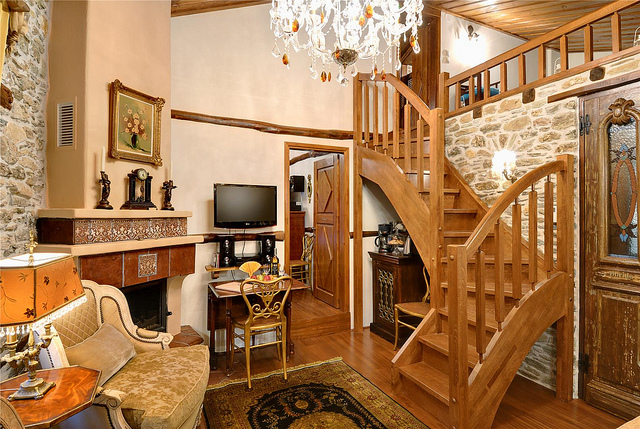

In [37]:
print(len(train_captions), len(img_name_vector))
print(train_captions[0])
Image.open(img_name_vector[0])

## 2 Image preprocessing
What we will do next is load the neural network that will take care of the vision part of the annotation problem. Indeed, the overall architecture of the system will contain two parts:
<ul>
<li>A CNN whose role will be to summarize and extract the raw and voluminous content of the information carried by the pixels into a compact representation that groups the essential characteristics to perform the annotation.</li>
<li>And an RNN that will have this compact representation as input and whose goal is to learn the next word from the first words of the annotation.</li>
</ul>

To create a new model you can use the `tf.keras.Model` function from [tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/Model). For the CNN part, you will not have to design your own architecture for the neural network, you must use an architecture that already exists and is called [InceptionV3](https://paperswithcode.com/method/inception-v3). You can download the weights of this architecture obtained by pre-training on the [ImageNet](http://www.image-net.org/) dataset (used in classification). This network will therefore be trained to do image classification, but you will use the last hidden layer of this network (i.e. the penultimate layer because the last one corresponds to the ImageNet classes), to later put it as input to your RNN. The RNN, as we said previously, will have to learn to do annotation based on these image representations.

Since training is usually done by making multiple passes over the data, the benefit of precomputing image representations is to avoid having to pass the images through the CNN each time and to avoid the training costs associated with the CNN. The potential downside is that performance will likely be more limited because training will only be on the RNN weights and not the CNN weights.

In [38]:
# Download the pre-trained InceptionV3 model with classification from ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
#Creation of a variable that will be the input to the new image pre-processing model
new_input =  image_model.input
# retrieve the last hidden layer containing the image in compact representation
hidden_layer = image_model.layers[-1].output

# Model that calculates a dense representation of images with InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


In [39]:
def load_image(image_path):
    """
    The load_image function has as its input as the path of an image and as its output as a pair
    containing the processed image and its path.
    The load_image function performs the following processing:
        1. Load the file corresponding to the path image_path
        2. Decodes the image into RGB.
        3. Resize image to size (299, 299).
        4. Normalise the image pixels between -1 and 1.
    """
    img = tf.io.read_file(image_path) #A COMPLETER
    img = tf.image.decode_jpeg(img, channels=3) #A COMPLETER
    img = tf.image.resize(img, (299,299)) #A COMPLETER
    img =  tf.keras.applications.inception_v3.preprocess_input(img) #A COMPLETER
    return img, image_path

Since we already have a pre-trained CNN, it is better to perform the training on the representations returned by the CNN because they are more compact and therefore less expensive in memory and time. To do this, it is advisable to cache them on disk if your RAM is not large enough. The last layer of the CNN has the shape `8x8x2048`. You will then store these images as `numpy.array` on disk using the `np.save()` function.

**Note:** Processing in TensorFlow is done in batches (it is easier for the GPU), so you must configure your batch to be able to pass your images into InceptionV3.

In [40]:
from tqdm import tqdm

# Pre-process images
# Take image names
encode_train = sorted(set(img_name_vector))

# Create an instance of “tf.data.Dataset” from image names
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
#  Data split into batches after pre-processing by load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

#Browse dataset batch by batch for InceptionV3 pre-processing
for img, path in tqdm(image_dataset):
    # InceptionV3 pre-processes current batch (size (16,8,8,2048))
    batch_features = image_features_extract_model(img) 
    # Resize batch from size (16,8,8,2048) to size (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Browse current batch and store path and batch with np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (image path associated with its new representation , image representation)
        np.save(path_of_feature, bf.numpy())

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [09:29<00:00,  4.56s/it]


# 3 Pre-processing annotations
To make annotations, we need to be able to process the text automatically by following the steps below:
<ul>
<li>Build a vocabulary of the words contained in the captions. To do this, we need to tokenize (divide) the words in the captions on special characters (spaces, punctuation, special signs, etc.).
<li>This vocabulary will be far too voluminous, so we'll have to limit ourselves to the first 5,000 most frequent words, for example. You can replace other words with a special token called “UNK” (unknown).
<li>The words must also be numbered in the dictionary to form annotations, represented in a way that is readable by word-processing algorithms.
<li>The examples (annotations) will be filled in so that they all have the same size (the maximum annotation size).
</ul>


In [41]:
# Find the maximum size
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Select the 5000 most frequent words in the vocabulary
top_k = 5000

#The Tokenizer class to enable text pre-processing for neural networks
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

# Build a vocabulary based on the train_captions list
tokenizer.fit_on_texts(train_captions)

# Create token to fill annotations to equalize length
tokenizer.word_index['<pad>'] =  0
tokenizer.index_word[0] = '<pad>'

# Create vectors (list of integer tokens) from annotations (list of words)
train_seqs =  tokenizer.texts_to_sequences(train_captions)

# Fill each vector up to maximum annotation length
cap_vector =tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the maximum length used to store attention weights
# It will be used later for display during evaluation
max_length = calc_max_length(train_seqs)

In [42]:
max_length

44

Later (in the next workshop - Captioning), we'll take up this second part and move on to the training and testing set, the construction of the model we're going to train, and the training and testing phase.